# Classification of Moscow Metro stations

## Introduction

Moscow Metro has 265 stations and is one of the largest public transit systems in the world. It is used by more than 6 million people daily.  
For this project, we want to look at the neighborhoods surrounding metro stations and classify them. Some neighborhoods are mostly residential, some have more business or commercial spaces surrounding them. The venues closest to a station determine why and how people use it. E.g. if there are no professional places in a neighborhood its residents are likely to travel to other areas for work. This creates daily migrations of people.  
By analyzing this data we can classify stations by primary usage. This data is useful for city planners to determine where from and where to people are most likely to travel for work and leisure. This can help plan further extension of the network and find places for new development.

## Data

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

### List of stations and their geographical coordinates
We can get the list of stations and their coordinates from Wikipedia

In [ ]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')

# get the table containing the postal codes
stations_table = wiki_doc.find('table', {'class': 'wikitable sortable'})

In [ ]:
# Grab English name, Russian name and coordinates (convert to comma-separated) from list
indices = [0,1,6]

stations_df = pd.DataFrame(columns=['English name','Russian name','Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    cells = tr.find_all('td')
    #ignore cells that don't have coordinates
    if cells[6].text.strip() != '':
        stations_df = stations_df.append({
            'English name': cells[0].text.strip(),
            'Russian name': cells[1].text.strip(),
            'Coordinates': cells[6].find('span', {'class': 'geo'}).text.strip().replace('; ',',')
        }, ignore_index=True)    
        
stations_df.head()
stations_df.to_csv('stations.csv')

In [2]:
stations_df = pd.read_csv('stations.csv', index_col=0)
stations_df.head()

,English name,Russian name,Coordinates
0,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342"
1,Cherkizovskaya,Черкизовская,"55.8038,37.7448"
2,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151"
3,Sokolniki,Сокольники,"55.7888,37.6802"
4,Krasnoselskaya,Красносельская,"55.7801,37.6673"


Let's visualize the stations data

In [34]:
#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)
#add markers
for station, coordinates in zip(stations_df['English name'], stations_df['Coordinates']):
    latlong = [float(x) for x in coordinates.split(',')]
    #Also add a 500-meter circle around the station to visualize our neighborhoods
    folium.Circle(
        latlong,        
        radius=1000
    ).add_to(map_moscow_metro)
    #Add marker with popup
    folium.Circle(
        latlong,
        popup=station,
        radius=20
    ).add_to(map_moscow_metro)
    
    
map_moscow_metro

### Venues and categories
We will use Foursquare API to explore venue categories surrounding each station. Venues can be categorized as residential, professional, shopping or leisure.
Let's see what venue categories Foursquare identifies.

In [3]:
secrets = json.load(open('secrets.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = secrets['VERSION']

In [4]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [172]:
len(results['response']['categories'])

10

There are 10 top-level categories and multiple subcategories

In [186]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Methodology 

We can use the foursquare explore API with categoryId to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [7]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [212]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [ ]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():    
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

In [42]:
#Read already stored CSV
stations_venues_df = pd.read_csv('stations_venues_1000.csv', index_col=0)
stations_venues_df.head()

,English name,Russian name,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342",5,8,0,11,6,9,46,6,55,9
1,Cherkizovskaya,Черкизовская,"55.8038,37.7448",5,25,0,12,4,19,38,7,36,10
2,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151",13,26,0,31,5,31,110,21,81,14
3,Sokolniki,Сокольники,"55.7888,37.6802",16,20,0,56,13,43,90,27,81,18
4,Krasnoselskaya,Красносельская,"55.7801,37.6673",31,25,0,107,28,25,134,23,91,70


### Exploratory analysis & basic cleanup
Plot the number of venues as boxplots

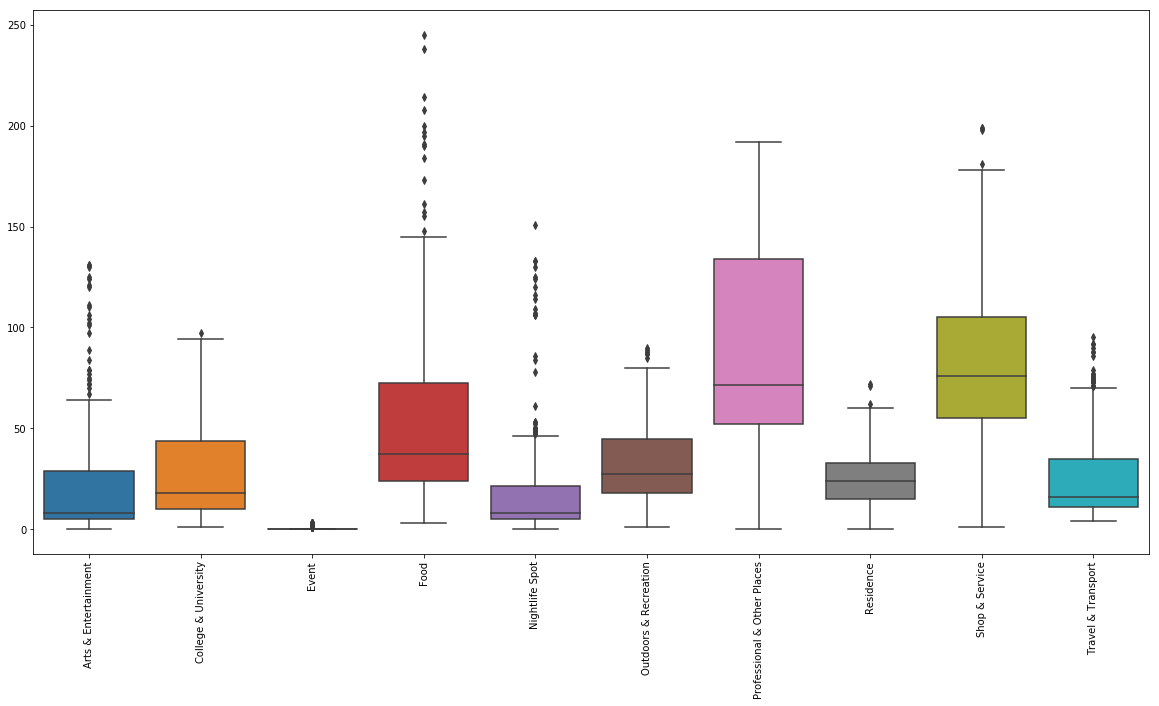

In [43]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)

plt.show()

The most frequent venue categories are professional, shop&service and food. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [ ]:
stations_venues_df.drop('Event', 1, inplace=True)

In [191]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

### Data preparation

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [199]:
from sklearn.preprocessing import MinMaxScaler

X = stations_venues_df.values[:,3:]
cluster_dataset = MinMaxScaler().fit_transform(X)

C:\Users\thept\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [200]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.038168,0.072917,0.033058,0.039735,0.089888,0.239583,0.083333,0.272727,0.054945
1,0.038168,0.250000,0.037190,0.026490,0.202247,0.197917,0.097222,0.176768,0.065934
2,0.099237,0.260417,0.115702,0.033113,0.337079,0.572917,0.291667,0.404040,0.109890
3,0.122137,0.197917,0.219008,0.086093,0.471910,0.468750,0.375000,0.404040,0.153846
4,0.236641,0.250000,0.429752,0.185430,0.269663,0.697917,0.319444,0.454545,0.725275


Visualize the scaled data.

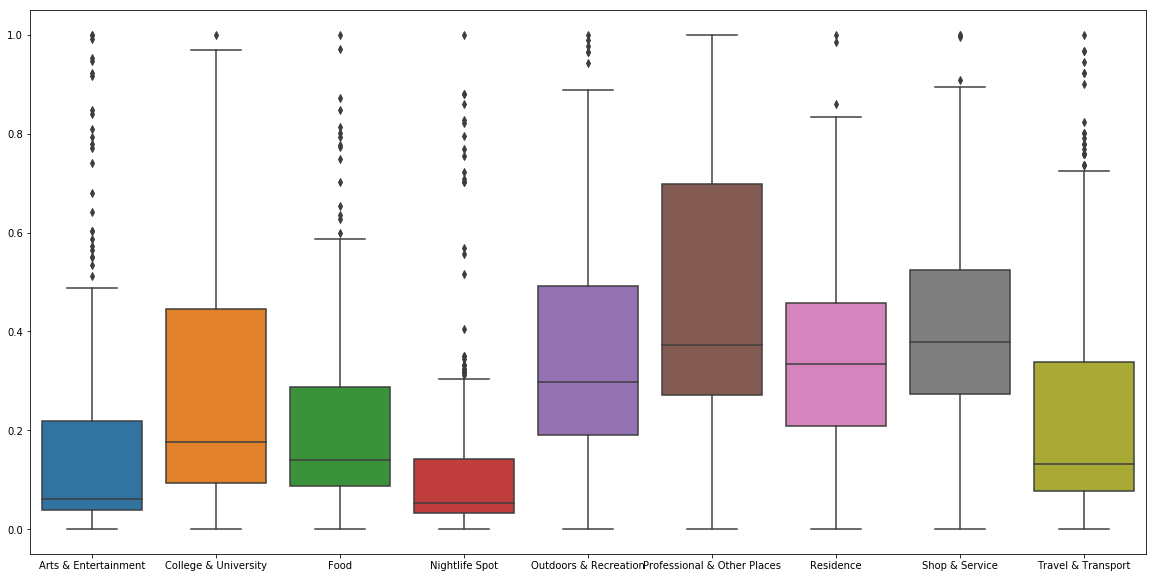

In [201]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)

plt.show()

### Clustering
We'll be using k-means clustering.
These were preliminary results with different number of clusters:  
- 2 clusters only show the uptown/downtown divide
- 3 clusters add clustering within the downtown
- 4 clusters also identify neighborhoods with very low number of venues
- 5 and more clusters are difficult to interpret  

For the final analysis let's settle on 4 clusters.

In [209]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:1, 2:0, 3:3}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English name'] = stations_df['English name']
stations_clusters_minmax_df['Coordinates'] = stations_df['Coordinates']

Visualize the clusters with boxplots

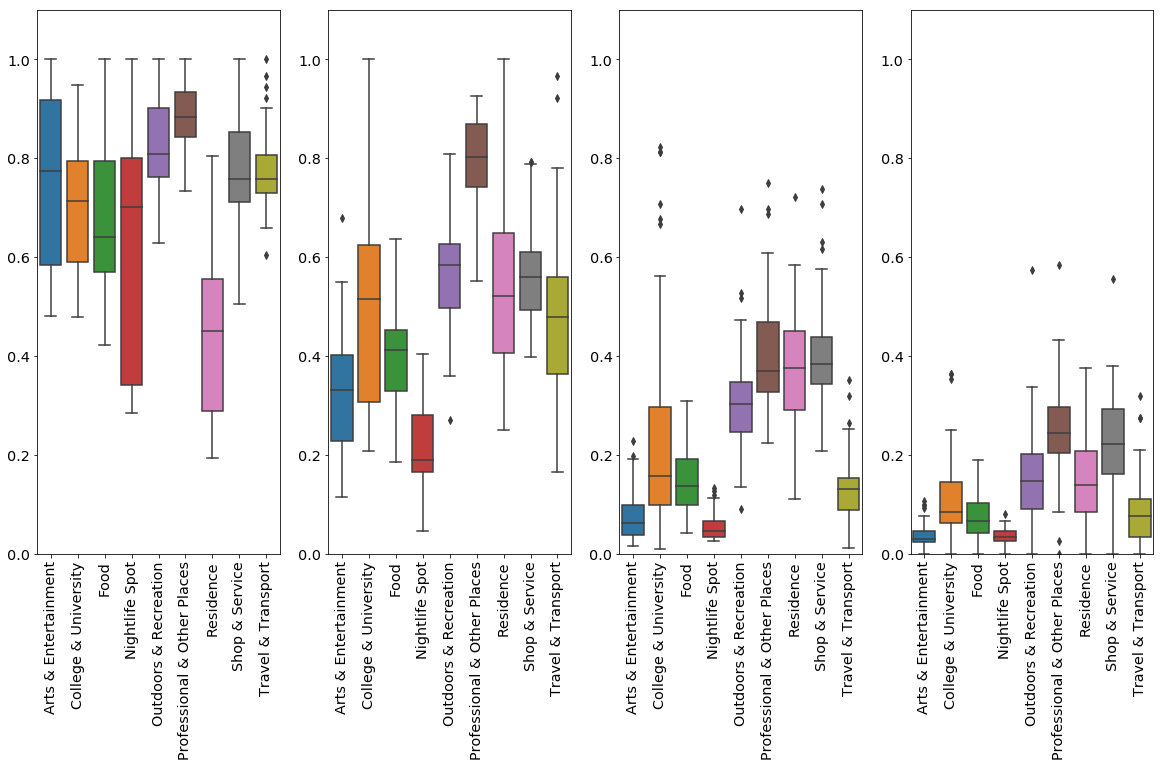

In [210]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10))

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].tick_params(labelsize='x-large')
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Map the data

In [208]:
#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)
#add markers
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English name'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_moscow_metro)
        
map_moscow_metro

## Results

underdeveloped neighborhoods

## Discussion

discussion

## Conclusion

Foursquare data can provide some insights but still limited